In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
from data_loaders import DataBlob
from utils import featurize, update_vars
import scanpy as sc
from modules.vae import GraphVAE
from torch import optim
from modules.losses import LossKZCP
from early_stopping import EarlyStopping
from tqdm import tqdm
import numpy as np
import seaborn as sns
import torch

In [4]:
dataset = DataBlob()

Injesting Data...: 100%|██████████| 4/4 [00:20<00:00,  5.11s/it]


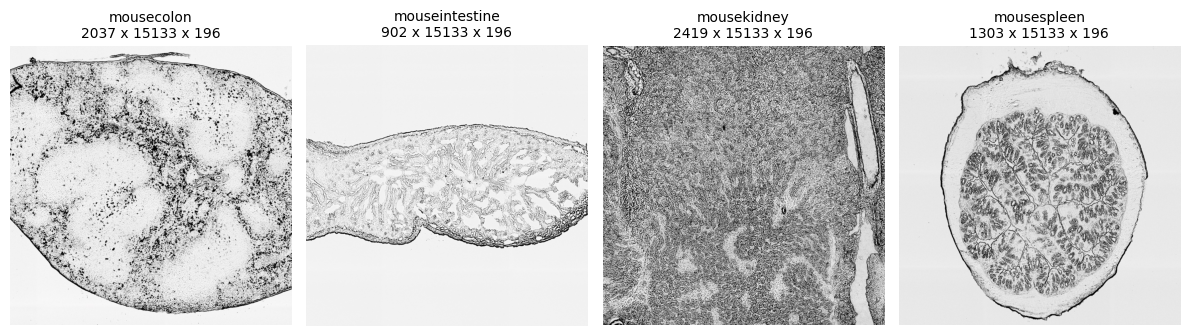

In [85]:
dataset.plot_data()

In [38]:
training_set = []

for i in [0, 1, 2]:
    _adata = dataset[i] 
    sc.pp.filter_genes(_adata, min_counts=10)
    sc.pp.filter_cells(_adata, min_counts=10)
    # _gex = featurize(_adata)
    training_set.append(_adata)

In [42]:
adata_val = dataset[3] 
common_genes = set.intersection(*map(set, [i.var_names for i in training_set+[adata_val]]))
adata_val = adata_val[:, [list(common_genes).index(i) for i in common_genes]]

training_set_x = []

for ada in training_set:
    ada = ada[:, [list(common_genes).index(i) for i in common_genes]]    
    f = featurize(ada)
    training_set_x.append(f)

In [43]:
gex_val = featurize(adata_val)

In [44]:
hidden1 = 128
hidden2 = hidden1 
hidden_decoder = hidden1
fc_dim1 = hidden1

dropout = 0.1
lr = 2e-5
weight_decay = 3e-5

In [50]:
model = GraphVAE(adata_val.shape[1], hidden1, hidden2, fc_dim1, dropout).cuda()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [ ]:
epochs = int(2e5)
plot_every = 100

loss_funcs_gex = LossKZCP()
loss_funcs_val = LossKZCP()


early_stopping = EarlyStopping(patience=20, verbose=False, delta=1e-3)

with tqdm(total=epochs, miniters=10, disable=False) as pbar:
    for e in range(epochs):
        for gex in training_set_x:
            model.train()        
            optimizer.zero_grad()

            output_gex = update_vars(model(gex.feature, gex.adj_norm), gex)

            loss = loss_funcs_gex.compute(output_gex) 
            loss.backward()
            optimizer.step()

            kl = np.mean(loss_funcs_gex.kl)
            ce = np.mean(loss_funcs_gex.ce)
            zinb = np.mean(loss_funcs_gex.zinb)
            loss_mean = np.mean(loss_funcs_gex.loss)

        early_stopping(loss_mean, model)   

        with torch.no_grad():
            model.eval()
            varz = update_vars(model(gex_val.feature, gex_val.adj_norm), gex_val)
            loss_funcs_val.ZINB(varz.features_recon, varz.feature, varz.train_nodes_idx, varz.features_raw)


        if early_stopping.early_stop:
            break
        
        pbar.set_description(f'Loss: {loss_mean:.3f} | KL: {kl:.3e} | Adjacency: {ce:.3f} | Re: {zinb:.3f} <> ReX: {np.mean(loss_funcs_val.zinb):.3f}')
        pbar.set_postfix_str(f'es: {early_stopping.counter+1}/{early_stopping.patience}')
        pbar.update()

Loss: 67.218 | KL: 3.066e-04 | Adjacency: 5.189 | Re: 56.553 <> ReX: 70.228:   0%|          | 673/200000 [00:44<3:43:45, 14.85it/s, es: 1/20]  

In [223]:
import matplotlib.pyplot as plt

In [246]:
model.eval()
o = model(gex.feature, gex.adj_norm)
o2 = model(gex2.feature, gex2.adj_norm)
recons = o.features_recon[-1].data.cpu().numpy()
feature = gex.feature.data.cpu().numpy()
recons2 = o2.features_recon[-1].data.cpu().numpy()
feature2 = gex2.feature.data.cpu().numpy()

<AxesSubplot: ylabel='Count'>

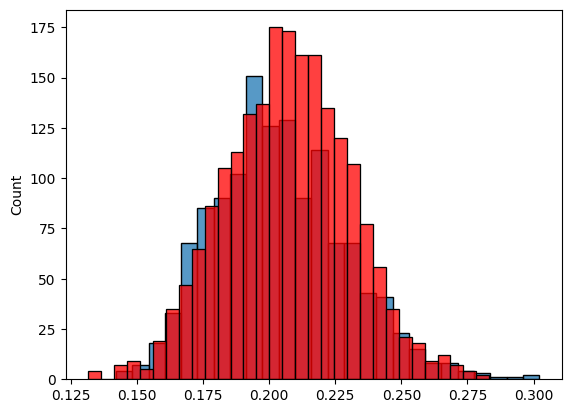

In [247]:
ixs = 112
sns.histplot(recons[:, ixs])
sns.histplot(recons2[:, ixs], color='red')

<AxesSubplot: ylabel='Count'>

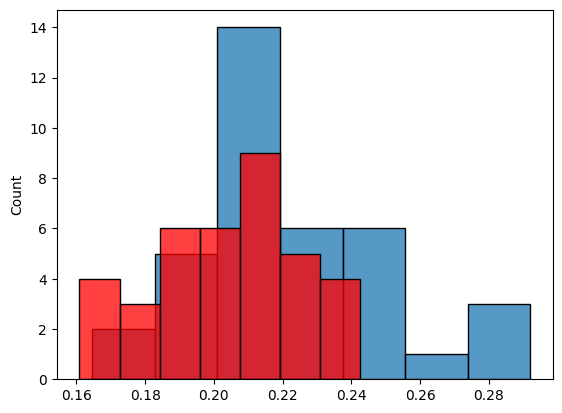

In [249]:
ixs = 6
idx = np.where(feature2[:, ixs]>0)[0]
sns.histplot(feature2[:, ixs][idx])
sns.histplot(recons2[:, ixs][idx], color='red')

In [250]:
from sklearn.metrics import r2_score 
from scipy.stats import spearmanr

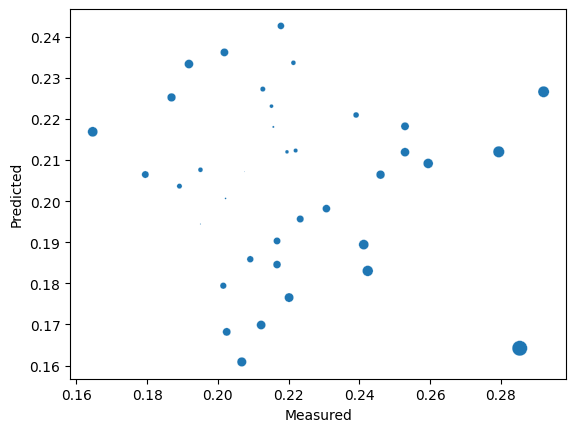

In [251]:
sns.scatterplot(feature2[:, ixs][idx], recons2[:, ixs][idx], s=1000*abs(feature2[:, ixs][idx]-recons2[:, ixs][idx]))
plt.xlabel('Measured')
plt.ylabel('Predicted')
# plt.title(spearmanr(feature2[:, ixs][idx], recons2[:, ixs][idx]).statistic)
plt.show()